In [33]:
import pandas as pd
import matplotlib.pyplot as plt 
from IPython.core.interactiveshell import InteractiveShell
from model import Actor, Critic
import torch
import numpy as np
from collections import deque

from environment import TradingEnv, train_agent

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

InteractiveShell.ast_node_interactivity = "all"

In [34]:
data_path = "../data/binance-BTCUSDT-1h.pkl"
df = pd.read_pickle(data_path)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


,open,high,low,close,volume,date_close
date_open,,,,,,
2020-03-31 00:00:00,6394.45,6469.28,6380.00,6439.55,3456.744826,2020-03-31 01:00:00
2020-03-31 01:00:00,6439.55,6515.00,6439.55,6514.07,2564.814102,2020-03-31 02:00:00
2020-03-31 02:00:00,6514.78,6523.23,6445.00,6449.66,2638.245186,2020-03-31 03:00:00
2020-03-31 03:00:00,6449.62,6480.00,6408.00,6439.47,3522.060908,2020-03-31 04:00:00
2020-03-31 04:00:00,6439.47,6465.00,6378.00,6398.93,3855.135175,2020-03-31 05:00:00


(37167, 6)

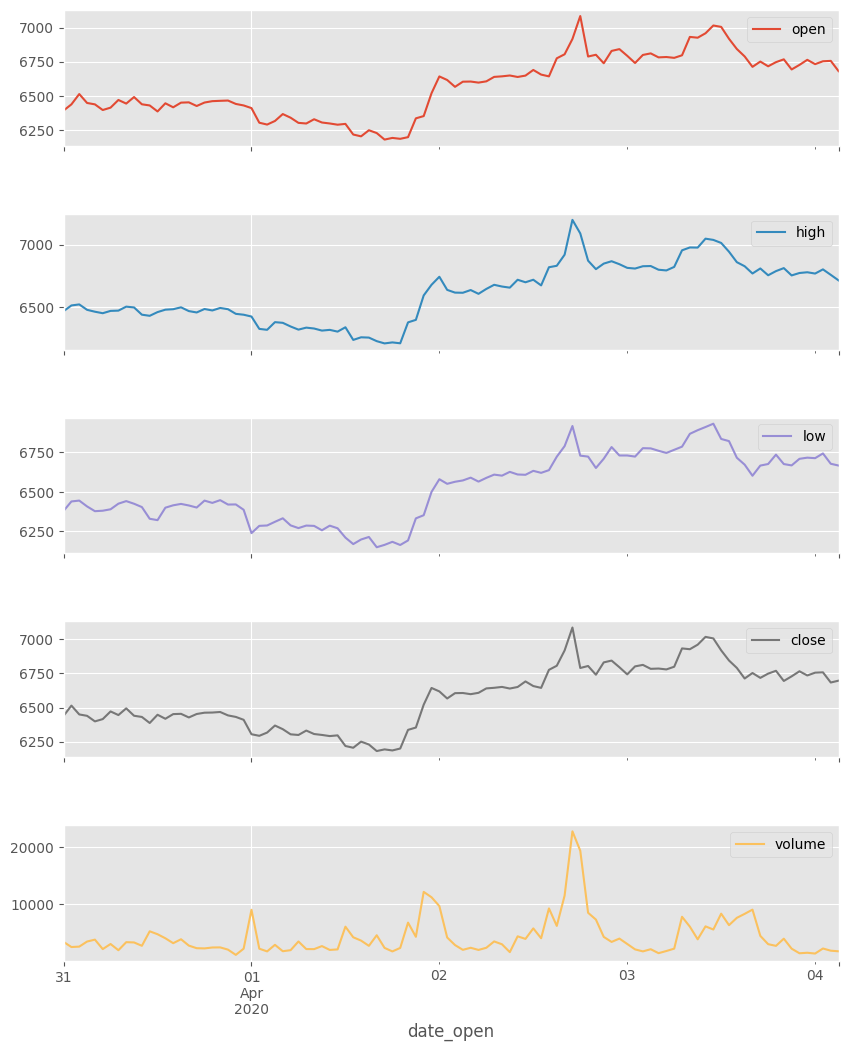

In [35]:
ax = df[df.columns[:5]][:100].plot(subplots=True, layout=(len(df.columns), 1), figsize=(10, 15))
plt.subplots_adjust(hspace=0.5)
plt.legend(loc='upper right', bbox_to_anchor=(0,0), ncol=1)
df.head()
df.shape

In [52]:
train_size = int(len(df) * 0.7)
train_df = df[:train_size]
test_df = df[train_size:]

lookback_window_size = 1
train_env = TradingEnv(train_df, initial_balance=1000, lookback_window_size=lookback_window_size, render_range=100)
env = train_env
#%load_ext tensorboard

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (1x10 and 500x256)

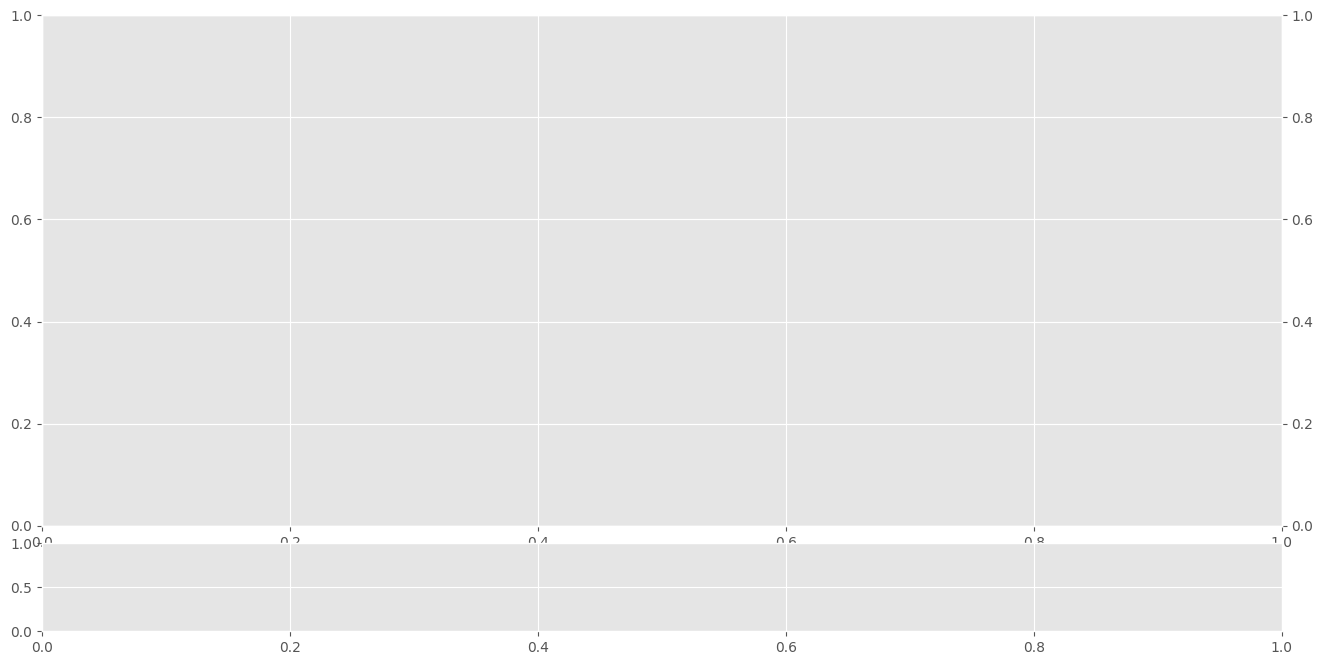

In [53]:
train_episodes = 5
training_batch_size = 1000
visualize=False
env.create_writer()
total_average = deque(maxlen=env.n_epochs)
best_average = 0
for episode in range(train_episodes):
    #state = env.reset(env_steps_size = training_batch_size)
    state = env.reset()
    
    states, actions, rewards, dones, next_states, log_prob_olds = [], [], [], [], [], []
    for _ in range(training_batch_size):
        env.render(visualize)
        action, log_prob_old = env.act(state, testmode=False) 
        next_state, reward, done = env.step(action)
        states.append(np.expand_dims(state, axis=0))
        next_states.append(np.expand_dims(next_state, axis=0))
        actions.append(action)
        rewards.append(reward)
        dones.append(done)
        log_prob_olds.append(log_prob_old)
        if done:
            break
        state = next_state
        
    env.optimize_model(states, actions, rewards, dones, next_states, log_prob_olds)
    total_average.append(env.net_worth)
    average = np.average(total_average)
    env.writer.add_scalar('./average_net_worth', average, episode)
    print(f"Episode {episode} net_worth: {env.net_worth}")

In [ ]:
fig = plt.figure()
x = np.linspace(stop=len(train_env.portfolio_value))
plt.plot(train_env.portfolio_value)

In [19]:
def train_agent(env, train_episodes, training_batch_size, visualize=False):
    env.create_writer()
    total_average = deque(maxlen=env.n_epochs)
    best_average = 0
    for episode in range(train_episodes):
        state = env.reset(env_steps_size = training_batch_size)
        #state = env.reset()
        
        states, actions, rewards, dones, next_states, log_prob_olds = [], [], [], [], [], []
        for _ in range(training_batch_size):
            env.render(visualize)
            action, log_prob_old = env.act(state, testmode=False) 
            next_state, reward, done = env.step(action)
            states.append(np.expand_dims(state, axis=0))
            next_states.append(np.expand_dims(next_state, axis=0))
            actions.append(action)
            rewards.append(reward)
            dones.append(done)
            log_prob_olds.append(log_prob_old)
            if done:
                break
            state = next_state
            
        env.optimize_model(states, actions, rewards, dones, next_states, log_prob_olds)
        total_average.append(env.net_worth)
        average = np.average(total_average)
        env.writer.add_scalar('./average_net_worth', average, episode)
        print(f"Episode {episode} net_worth: {env.net_worth}")
        if episode == train_episodes - 1:
            env.save()

In [61]:
value_losses = pd.read_csv("policy_loss.csv", header=None)

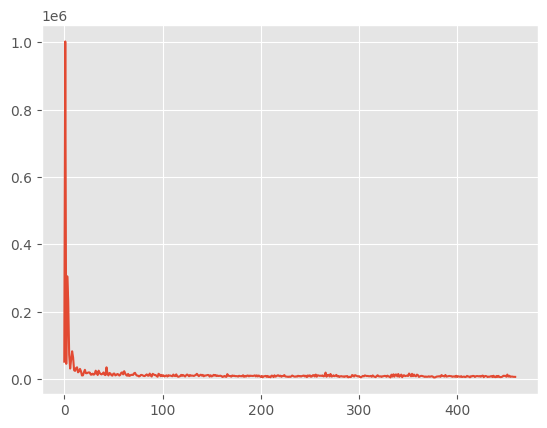

In [64]:
plt.plot(value_losses.index.values, value_losses)

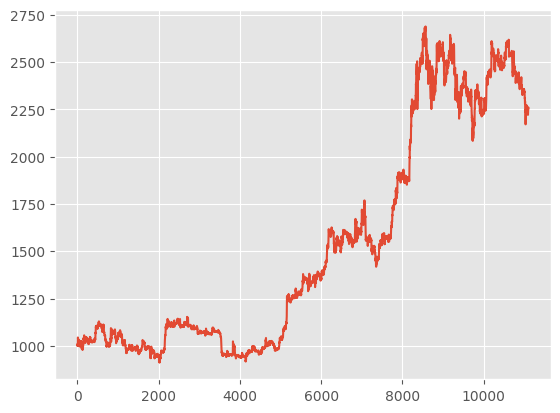

In [65]:
portfolio_values = pd.read_csv("portfolio_values.csv", header=None)
plt.plot(portfolio_values.index.values, portfolio_values)